# Second order stochastic methods for CryoEM

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops, get_cg_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.algorithm import oasis, oasis_adaptive
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [3]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles: 105519
load_data: data loaded, time:  70.19 sec.


In [4]:
out_dir = out_dir = '../data/out_dev/'

In [5]:
nx0 = imgs0.shape[1]
nx_crop = 64 #128
N = 20000 #80000
N_px_noise = 48
N_imgs_noise=1000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop, N = N, N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

imgs0.shape = (105519, 320, 320)
pixel_size0.shape = (105519,)
angles0.shape = (105519, 3)
shifts0.shape = (105519, 2)
ctf_params0.shape = (105519, 9)
Shuffle = False
N = 20000
Taking FFT of the images:
Batch 1/10  5.54 sec.
Batch 2/10  5.52 sec.
Batch 3/10  5.54 sec.
Batch 4/10  5.53 sec.
Batch 5/10  5.54 sec.
Batch 6/10  5.54 sec.
Batch 7/10  5.52 sec.
Batch 8/10  5.52 sec.
Batch 9/10  5.54 sec.
Batch 10/10  5.54 sec.
FFT done. Time:  68.28 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 6.40000000e+01]
Vectorised imgs_f.shape = (20000, 4096)
Mask radius = 0.0739503816793893
Estimating the noise using the 48 x 48 corners of the first 1000 images.
Estimating pixel-wise noise...done.
Averaging radially...done.
Noise estimation done. Time:  10.93 sec.


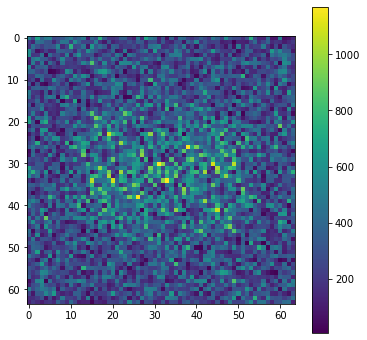

In [6]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[135].reshape([nx_crop,nx_crop]))));plt.colorbar()

In [7]:
#del(imgs0)

### Only volume reconstruction for now - SGD vs OASIS

Obervations:

* The loss and grad don't tell us anything about convergence. The loss is about the same after only 100 iterations and after 10 epochs (of 781 iters each), and yet the result is different
* SGD seems to overfit at small batch size (e.g. 32) - better objective (??? maybe there's something wrong with how I calculate loss_epoch) but much worse FSC. Batch size = 1000 seems good for both methods, interestingly the OASIS FSC stays above 0.9 for all resolutions (up to 6.6 Angs for nx=128 -> maybe try a bit higher?).

In [8]:
sigma_noise_est = sigma_noise
sigma_noise = jnp.ones(sigma_noise.shape)

In [9]:
# Apply mask to images
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [10]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [117]:
alpha = 1e-9

slice_obj = Slice(x_grid, mask = mask)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

Use the same datasets, loss, grad, hvp, x0, D0 for SGD and OASIS

In [118]:
idxrand = np.random.permutation(N)
idx1 = idxrand[:N//2]
idx2 = idxrand[N//2:]

In [119]:
grad_func1, loss_func1, hvp_func1 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], sigma_noise)
grad_func2, loss_func2, hvp_func2 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [120]:
iters = 2000
batch_sz = 100
key, *subkeys = random.split(key, 2*iters+1)

zD01z = np.zeros([nx,nx,nx])
zD02z = np.zeros([nx,nx,nx])

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], [nx,nx,nx], dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N//2)[:batch_sz]
    
    zD01z += z * hvp_func1(x0, z, idx)
    zD02z += z * hvp_func2(x0, z, idx)
    
D01 = jnp.array(zD01z/iters)
D02 = jnp.array(zD02z/iters)

100%|██████████| 2000/2000 [00:54<00:00, 36.95it/s]


1.0000000000000342e-09
0.02812796183878146
28127961.8387805


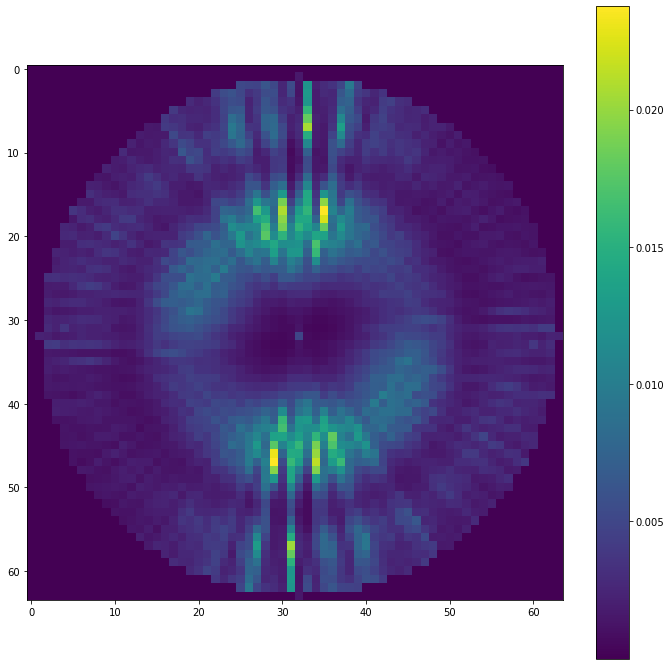

In [121]:
plt.imshow(jnp.fft.fftshift(jnp.abs(D01[0,:,:]))); plt.colorbar()
print(jnp.min(jnp.abs(D01)))
print(jnp.max(jnp.abs(D01)))
print(jnp.max(jnp.abs(D01))/jnp.min(jnp.abs(D01)))

1.0000000000000342e-09
0.02812796183878146


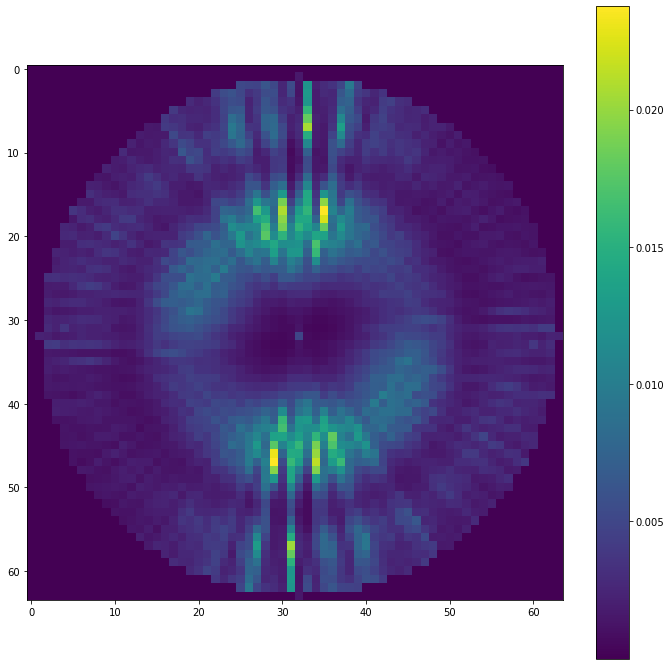

In [122]:
DD = jnp.maximum(jnp.abs(D01), 1e-9)
plt.imshow(jnp.fft.fftshift(jnp.abs(DD[0,:,:]))); plt.colorbar()
print(jnp.min(jnp.abs(DD)))
print(jnp.max(jnp.abs(DD)))

In [123]:
print(jnp.max(jnp.abs(D01)))
print(jnp.max(jnp.abs(D02)))
print(jnp.max(jnp.abs(D01-D02)))

0.02812796183878146
0.028177293005872385
0.0032995433998736466


#### SGD

In [124]:
N_epochs = 30
batch_size = 1000
step_size = 1e-5 #1e-2 #1000000 # 1e-3

In [125]:
#P1 = None
P1 = 1/D01

v_rec1, loss_rec1, grad_rec1 = sgd(grad_func1, loss_func1, N//2, x0, step_size, N_epochs, batch_size, P = P1, verbose=True, iter_display=1)


Epoch 1/30 

100%|██████████| 10/10 [00:09<00:00,  1.04it/s, grad=2.949e+01, loss=3.398e+08]


  |Grad| = 3.109e+01
  Loss = 3.408e+08
Epoch 2/30 

100%|██████████| 10/10 [00:01<00:00,  5.98it/s, grad=3.247e+01, loss=3.418e+08]


  |Grad| = 3.109e+01
  Loss = 3.408e+08
Epoch 3/30 

100%|██████████| 10/10 [00:01<00:00,  6.08it/s, grad=3.174e+01, loss=3.369e+08]


  |Grad| = 3.124e+01
  Loss = 3.407e+08
Epoch 4/30 

100%|██████████| 10/10 [00:01<00:00,  5.99it/s, grad=3.179e+01, loss=3.420e+08]


  |Grad| = 3.185e+01
  Loss = 3.407e+08
Epoch 5/30 

100%|██████████| 10/10 [00:01<00:00,  5.98it/s, grad=3.023e+01, loss=3.408e+08]


  |Grad| = 3.154e+01
  Loss = 3.407e+08
Epoch 6/30 

100%|██████████| 10/10 [00:01<00:00,  6.04it/s, grad=2.907e+01, loss=3.460e+08]


  |Grad| = 3.289e+01
  Loss = 3.407e+08
Epoch 7/30 

100%|██████████| 10/10 [00:01<00:00,  6.02it/s, grad=3.006e+01, loss=3.451e+08]


  |Grad| = 3.178e+01
  Loss = 3.407e+08
Epoch 8/30 

100%|██████████| 10/10 [00:01<00:00,  6.05it/s, grad=3.051e+01, loss=3.443e+08]


  |Grad| = 3.170e+01
  Loss = 3.407e+08
Epoch 9/30 

100%|██████████| 10/10 [00:01<00:00,  6.00it/s, grad=3.217e+01, loss=3.447e+08]


  |Grad| = 3.096e+01
  Loss = 3.407e+08
Epoch 10/30 

100%|██████████| 10/10 [00:01<00:00,  6.04it/s, grad=3.151e+01, loss=3.362e+08]


  |Grad| = 3.191e+01
  Loss = 3.407e+08
Epoch 11/30 

100%|██████████| 10/10 [00:01<00:00,  5.98it/s, grad=3.366e+01, loss=3.425e+08]


  |Grad| = 3.091e+01
  Loss = 3.407e+08
Epoch 12/30 

100%|██████████| 10/10 [00:01<00:00,  5.92it/s, grad=4.111e+01, loss=3.399e+08]


  |Grad| = 3.236e+01
  Loss = 3.406e+08
Epoch 13/30 

100%|██████████| 10/10 [00:01<00:00,  6.07it/s, grad=2.979e+01, loss=3.450e+08]


  |Grad| = 3.114e+01
  Loss = 3.406e+08
Epoch 14/30 

100%|██████████| 10/10 [00:01<00:00,  5.98it/s, grad=3.676e+01, loss=3.456e+08]


  |Grad| = 3.190e+01
  Loss = 3.406e+08
Epoch 15/30 

100%|██████████| 10/10 [00:01<00:00,  6.05it/s, grad=3.246e+01, loss=3.396e+08]


  |Grad| = 3.211e+01
  Loss = 3.406e+08
Epoch 16/30 

100%|██████████| 10/10 [00:01<00:00,  6.05it/s, grad=3.045e+01, loss=3.409e+08]


  |Grad| = 3.247e+01
  Loss = 3.406e+08
Epoch 17/30 

100%|██████████| 10/10 [00:01<00:00,  6.01it/s, grad=2.989e+01, loss=3.420e+08]


  |Grad| = 3.119e+01
  Loss = 3.406e+08
Epoch 18/30 

100%|██████████| 10/10 [00:01<00:00,  6.02it/s, grad=3.193e+01, loss=3.368e+08]


  |Grad| = 3.175e+01
  Loss = 3.406e+08
Epoch 19/30 

100%|██████████| 10/10 [00:01<00:00,  6.02it/s, grad=3.572e+01, loss=3.425e+08]


  |Grad| = 3.070e+01
  Loss = 3.406e+08
Epoch 20/30 

100%|██████████| 10/10 [00:01<00:00,  6.06it/s, grad=3.447e+01, loss=3.410e+08]


  |Grad| = 3.116e+01
  Loss = 3.405e+08
Epoch 21/30 

100%|██████████| 10/10 [00:01<00:00,  6.00it/s, grad=3.284e+01, loss=3.424e+08]


  |Grad| = 3.166e+01
  Loss = 3.405e+08
Epoch 22/30 

100%|██████████| 10/10 [00:01<00:00,  6.06it/s, grad=3.428e+01, loss=3.395e+08]


  |Grad| = 3.162e+01
  Loss = 3.405e+08
Epoch 23/30 

100%|██████████| 10/10 [00:01<00:00,  6.04it/s, grad=2.631e+01, loss=3.404e+08]


  |Grad| = 3.148e+01
  Loss = 3.405e+08
Epoch 24/30 

100%|██████████| 10/10 [00:01<00:00,  6.00it/s, grad=3.046e+01, loss=3.437e+08]


  |Grad| = 3.237e+01
  Loss = 3.405e+08
Epoch 25/30 

100%|██████████| 10/10 [00:01<00:00,  6.00it/s, grad=2.833e+01, loss=3.354e+08]


  |Grad| = 3.105e+01
  Loss = 3.405e+08
Epoch 26/30 

100%|██████████| 10/10 [00:01<00:00,  6.05it/s, grad=3.098e+01, loss=3.414e+08]


  |Grad| = 3.089e+01
  Loss = 3.405e+08
Epoch 27/30 

100%|██████████| 10/10 [00:01<00:00,  5.98it/s, grad=3.170e+01, loss=3.381e+08]


  |Grad| = 3.168e+01
  Loss = 3.405e+08
Epoch 28/30 

100%|██████████| 10/10 [00:01<00:00,  6.04it/s, grad=3.080e+01, loss=3.388e+08]


  |Grad| = 3.231e+01
  Loss = 3.404e+08
Epoch 29/30 

100%|██████████| 10/10 [00:01<00:00,  6.06it/s, grad=3.002e+01, loss=3.354e+08]


  |Grad| = 3.113e+01
  Loss = 3.404e+08
Epoch 30/30 

100%|██████████| 10/10 [00:01<00:00,  5.98it/s, grad=3.364e+01, loss=3.359e+08]

  |Grad| = 3.219e+01
  Loss = 3.404e+08


In [126]:
#P2 = None
P2 = 1/D02

v_rec2, loss_rec2, grad_rec2 = sgd(grad_func2, loss_func2, N//2, x0, step_size, N_epochs, batch_size, P = P2, verbose=True, iter_display=1)


Epoch 1/30 

100%|██████████| 10/10 [00:01<00:00,  6.03it/s, grad=3.599e+01, loss=3.415e+08]


  |Grad| = 3.043e+01
  Loss = 3.401e+08
Epoch 2/30 

100%|██████████| 10/10 [00:01<00:00,  6.01it/s, grad=3.021e+01, loss=3.418e+08]


  |Grad| = 3.044e+01
  Loss = 3.401e+08
Epoch 3/30 

100%|██████████| 10/10 [00:01<00:00,  6.05it/s, grad=3.197e+01, loss=3.409e+08]


  |Grad| = 2.984e+01
  Loss = 3.401e+08
Epoch 4/30 

100%|██████████| 10/10 [00:01<00:00,  6.03it/s, grad=2.973e+01, loss=3.418e+08]


  |Grad| = 3.095e+01
  Loss = 3.401e+08
Epoch 5/30 

100%|██████████| 10/10 [00:01<00:00,  6.00it/s, grad=2.718e+01, loss=3.396e+08]


  |Grad| = 2.965e+01
  Loss = 3.401e+08
Epoch 6/30 

100%|██████████| 10/10 [00:01<00:00,  6.08it/s, grad=3.092e+01, loss=3.442e+08]


  |Grad| = 3.028e+01
  Loss = 3.401e+08
Epoch 7/30 

100%|██████████| 10/10 [00:01<00:00,  6.06it/s, grad=3.281e+01, loss=3.447e+08]


  |Grad| = 3.087e+01
  Loss = 3.401e+08
Epoch 8/30 

100%|██████████| 10/10 [00:01<00:00,  6.02it/s, grad=2.599e+01, loss=3.408e+08]


  |Grad| = 3.036e+01
  Loss = 3.401e+08
Epoch 9/30 

100%|██████████| 10/10 [00:01<00:00,  6.02it/s, grad=2.698e+01, loss=3.427e+08]


  |Grad| = 3.061e+01
  Loss = 3.401e+08
Epoch 10/30 

100%|██████████| 10/10 [00:01<00:00,  6.02it/s, grad=3.067e+01, loss=3.364e+08]


  |Grad| = 3.070e+01
  Loss = 3.400e+08
Epoch 11/30 

100%|██████████| 10/10 [00:01<00:00,  6.00it/s, grad=3.254e+01, loss=3.393e+08]


  |Grad| = 3.067e+01
  Loss = 3.400e+08
Epoch 12/30 

100%|██████████| 10/10 [00:01<00:00,  6.07it/s, grad=3.063e+01, loss=3.369e+08]


  |Grad| = 3.015e+01
  Loss = 3.400e+08
Epoch 13/30 

100%|██████████| 10/10 [00:01<00:00,  6.05it/s, grad=2.929e+01, loss=3.405e+08]


  |Grad| = 3.046e+01
  Loss = 3.400e+08
Epoch 14/30 

100%|██████████| 10/10 [00:01<00:00,  6.03it/s, grad=2.971e+01, loss=3.405e+08]


  |Grad| = 2.974e+01
  Loss = 3.400e+08
Epoch 15/30 

100%|██████████| 10/10 [00:01<00:00,  6.09it/s, grad=3.171e+01, loss=3.401e+08]


  |Grad| = 3.091e+01
  Loss = 3.400e+08
Epoch 16/30 

100%|██████████| 10/10 [00:01<00:00,  6.06it/s, grad=3.347e+01, loss=3.416e+08]


  |Grad| = 3.150e+01
  Loss = 3.400e+08
Epoch 17/30 

100%|██████████| 10/10 [00:01<00:00,  6.01it/s, grad=2.768e+01, loss=3.386e+08]


  |Grad| = 3.078e+01
  Loss = 3.400e+08
Epoch 18/30 

100%|██████████| 10/10 [00:01<00:00,  6.02it/s, grad=2.834e+01, loss=3.435e+08]


  |Grad| = 3.005e+01
  Loss = 3.399e+08
Epoch 19/30 

100%|██████████| 10/10 [00:01<00:00,  6.02it/s, grad=2.792e+01, loss=3.401e+08]


  |Grad| = 3.023e+01
  Loss = 3.399e+08
Epoch 20/30 

100%|██████████| 10/10 [00:01<00:00,  6.06it/s, grad=2.974e+01, loss=3.420e+08]


  |Grad| = 3.048e+01
  Loss = 3.399e+08
Epoch 21/30 

100%|██████████| 10/10 [00:01<00:00,  6.03it/s, grad=3.211e+01, loss=3.384e+08]


  |Grad| = 3.049e+01
  Loss = 3.399e+08
Epoch 22/30 

100%|██████████| 10/10 [00:01<00:00,  6.08it/s, grad=2.929e+01, loss=3.405e+08]


  |Grad| = 3.097e+01
  Loss = 3.399e+08
Epoch 23/30 

100%|██████████| 10/10 [00:01<00:00,  6.02it/s, grad=2.677e+01, loss=3.380e+08]


  |Grad| = 3.099e+01
  Loss = 3.399e+08
Epoch 24/30 

100%|██████████| 10/10 [00:01<00:00,  6.10it/s, grad=2.971e+01, loss=3.423e+08]


  |Grad| = 2.956e+01
  Loss = 3.399e+08
Epoch 25/30 

100%|██████████| 10/10 [00:01<00:00,  5.95it/s, grad=3.115e+01, loss=3.412e+08]


  |Grad| = 3.126e+01
  Loss = 3.399e+08
Epoch 26/30 

100%|██████████| 10/10 [00:01<00:00,  5.95it/s, grad=3.380e+01, loss=3.405e+08]


  |Grad| = 2.985e+01
  Loss = 3.398e+08
Epoch 27/30 

100%|██████████| 10/10 [00:01<00:00,  6.00it/s, grad=2.608e+01, loss=3.374e+08]


  |Grad| = 3.004e+01
  Loss = 3.398e+08
Epoch 28/30 

100%|██████████| 10/10 [00:01<00:00,  5.98it/s, grad=2.545e+01, loss=3.379e+08]


  |Grad| = 2.944e+01
  Loss = 3.398e+08
Epoch 29/30 

100%|██████████| 10/10 [00:01<00:00,  6.03it/s, grad=3.023e+01, loss=3.395e+08]


  |Grad| = 3.042e+01
  Loss = 3.398e+08
Epoch 30/30 

100%|██████████| 10/10 [00:01<00:00,  5.99it/s, grad=2.763e+01, loss=3.408e+08]

  |Grad| = 3.033e+01
  Loss = 3.398e+08


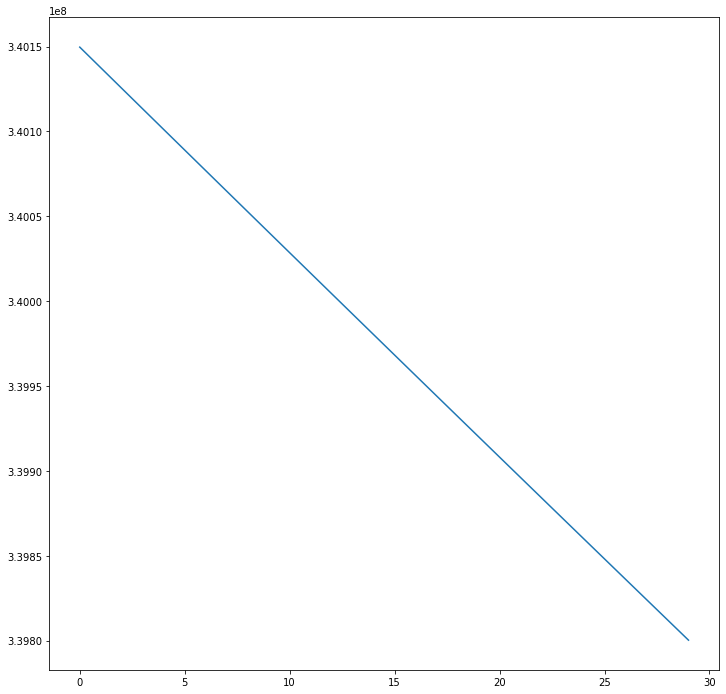

In [127]:
plt.plot(loss_rec2)

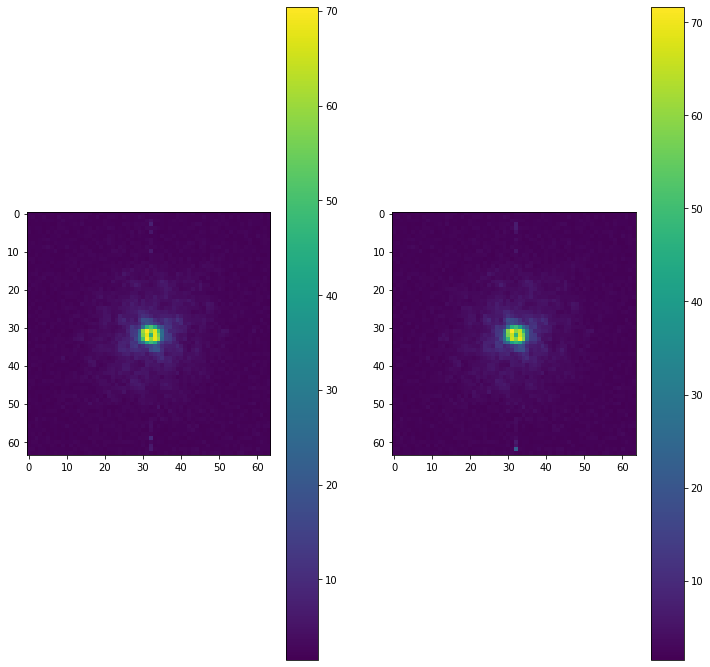

In [128]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec2))); plt.colorbar()

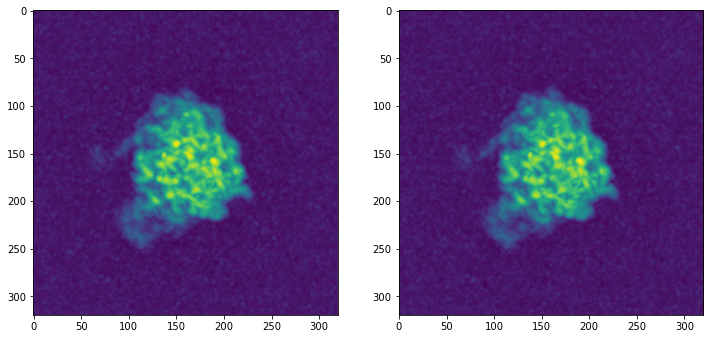

In [129]:
v_rec_l1, _ = rescale_larger_grid(v_rec1, x_grid, nx0)
vr_sgd1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l1)))

v_rec_l2, _ = rescale_larger_grid(v_rec2, x_grid, nx0)
vr_sgd2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l2)))

plt.subplot(1,2,1)
mip_z(vr_sgd1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_sgd2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [130]:
with mrcfile.new(f"{out_dir}/v_rec_sgd1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_sgd2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd2.astype(np.float32))   

Text(0.5, 1.0, 'FSC')

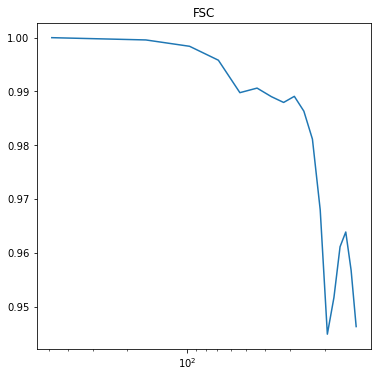

In [131]:
res, fsc_sgd, shell_points = calc_fsc(v_rec1, v_rec2, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_sgd)
plt.gca().invert_xaxis()
plt.title("FSC")

In [132]:
print(fsc_sgd[11])
print(fsc_sgd[12])
print(res_angs[11])
print(res_angs[12])

0.9679769912314818
0.9448614352245729
21.04567242124271
19.362018627543293


#### OASIS

#### Something is wrong here (later edit: not that wrong):

* Also the OASIS rec with fixed rate should be the same as SGD with D0 preconditioner, so the loss and results should be the same. What's wrong? Ok not really the same as the diagonal keeps getting updated in OASIS (althoug it's constant and shouldn't need any more updating in this particular case). Still not clear why it's better than SGD with the diagonal preconditioner -- is it because of the sampling of the diagonal? 
* Work with a dataset with no heterogeneity
* Still don't know why the adaptive version fails

In [207]:
N_epoch = 30
beta2 = 1 #0.99
eta0 = 1e-5 #1e-4 #0.0001 #0.1/0.001/0.01/0.15
batch_size = 1000
alpha = 0 #1e-16 #0.1 # 0.01

D0bad = jnp.array(np.random.randn(*D01.shape))

key, subkey = random.split(key)

In [208]:

v_rec_o1, loss_o1 = oasis(subkey, loss_func1, grad_func1, hvp_func1, x0, eta0, D01, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


Epoch 1/30


100%|██████████| 10/10 [00:02<00:00,  3.89it/s, loss=3.436e+08]


  Loss =  3.408e+08
Epoch 2/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.382e+08]


  Loss =  3.408e+08
Epoch 3/30


100%|██████████| 10/10 [00:02<00:00,  3.95it/s, loss=3.427e+08]


  Loss =  3.408e+08
Epoch 4/30


100%|██████████| 10/10 [00:02<00:00,  3.93it/s, loss=3.423e+08]


  Loss =  3.408e+08
Epoch 5/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.412e+08]


  Loss =  3.408e+08
Epoch 6/30


100%|██████████| 10/10 [00:02<00:00,  3.90it/s, loss=3.405e+08]


  Loss =  3.408e+08
Epoch 7/30


100%|██████████| 10/10 [00:02<00:00,  3.93it/s, loss=3.402e+08]


  Loss =  3.408e+08
Epoch 8/30


100%|██████████| 10/10 [00:02<00:00,  3.94it/s, loss=3.404e+08]


  Loss =  3.408e+08
Epoch 9/30


100%|██████████| 10/10 [00:02<00:00,  3.87it/s, loss=3.393e+08]


  Loss =  3.408e+08
Epoch 10/30


100%|██████████| 10/10 [00:02<00:00,  3.90it/s, loss=3.433e+08]


  Loss =  3.408e+08
Epoch 11/30


100%|██████████| 10/10 [00:02<00:00,  3.88it/s, loss=3.399e+08]


  Loss =  3.408e+08
Epoch 12/30


100%|██████████| 10/10 [00:02<00:00,  3.91it/s, loss=3.404e+08]


  Loss =  3.407e+08
Epoch 13/30


100%|██████████| 10/10 [00:02<00:00,  3.89it/s, loss=3.398e+08]


  Loss =  3.407e+08
Epoch 14/30


100%|██████████| 10/10 [00:02<00:00,  3.88it/s, loss=3.433e+08]


  Loss =  3.407e+08
Epoch 15/30


100%|██████████| 10/10 [00:02<00:00,  3.87it/s, loss=3.422e+08]


  Loss =  3.407e+08
Epoch 16/30


100%|██████████| 10/10 [00:02<00:00,  3.91it/s, loss=3.369e+08]


  Loss =  3.407e+08
Epoch 17/30


100%|██████████| 10/10 [00:02<00:00,  3.87it/s, loss=3.393e+08]


  Loss =  3.407e+08
Epoch 18/30


100%|██████████| 10/10 [00:02<00:00,  3.91it/s, loss=3.441e+08]


  Loss =  3.407e+08
Epoch 19/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.421e+08]


  Loss =  3.407e+08
Epoch 20/30


100%|██████████| 10/10 [00:02<00:00,  3.95it/s, loss=3.389e+08]


  Loss =  3.407e+08
Epoch 21/30


100%|██████████| 10/10 [00:02<00:00,  3.94it/s, loss=3.407e+08]


  Loss =  3.407e+08
Epoch 22/30


100%|██████████| 10/10 [00:02<00:00,  3.97it/s, loss=3.384e+08]


  Loss =  3.407e+08
Epoch 23/30


100%|██████████| 10/10 [00:02<00:00,  3.95it/s, loss=3.366e+08]


  Loss =  3.407e+08
Epoch 24/30


100%|██████████| 10/10 [00:02<00:00,  3.92it/s, loss=3.411e+08]


  Loss =  3.407e+08
Epoch 25/30


100%|██████████| 10/10 [00:02<00:00,  3.89it/s, loss=3.431e+08]


  Loss =  3.407e+08
Epoch 26/30


100%|██████████| 10/10 [00:02<00:00,  3.93it/s, loss=3.438e+08]


  Loss =  3.407e+08
Epoch 27/30


100%|██████████| 10/10 [00:02<00:00,  3.94it/s, loss=3.397e+08]


  Loss =  3.407e+08
Epoch 28/30


100%|██████████| 10/10 [00:02<00:00,  3.94it/s, loss=3.432e+08]


  Loss =  3.407e+08
Epoch 29/30


100%|██████████| 10/10 [00:02<00:00,  3.95it/s, loss=3.395e+08]


  Loss =  3.407e+08
Epoch 30/30


100%|██████████| 10/10 [00:02<00:00,  3.90it/s, loss=3.445e+08]

  Loss =  3.407e+08


In [209]:
#v_rec_oa1, loss_oa1 = oasis_adaptive(subkey, loss_func1, grad_func1, hvp_func1, x0, eta0, D01, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


In [210]:
v_rec_o2, loss_o2 = oasis(subkey, loss_func2, grad_func2, hvp_func2, x0, eta0, D02, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


Epoch 1/30


100%|██████████| 10/10 [00:02<00:00,  3.95it/s, loss=3.406e+08]


  Loss =  3.402e+08
Epoch 2/30


100%|██████████| 10/10 [00:02<00:00,  3.92it/s, loss=3.363e+08]


  Loss =  3.402e+08
Epoch 3/30


100%|██████████| 10/10 [00:02<00:00,  3.88it/s, loss=3.419e+08]


  Loss =  3.401e+08
Epoch 4/30


100%|██████████| 10/10 [00:02<00:00,  3.95it/s, loss=3.408e+08]


  Loss =  3.401e+08
Epoch 5/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.393e+08]


  Loss =  3.401e+08
Epoch 6/30


100%|██████████| 10/10 [00:02<00:00,  3.92it/s, loss=3.383e+08]


  Loss =  3.401e+08
Epoch 7/30


100%|██████████| 10/10 [00:02<00:00,  3.95it/s, loss=3.395e+08]


  Loss =  3.401e+08
Epoch 8/30


100%|██████████| 10/10 [00:02<00:00,  3.92it/s, loss=3.416e+08]


  Loss =  3.401e+08
Epoch 9/30


100%|██████████| 10/10 [00:02<00:00,  3.88it/s, loss=3.387e+08]


  Loss =  3.401e+08
Epoch 10/30


100%|██████████| 10/10 [00:02<00:00,  3.97it/s, loss=3.401e+08]


  Loss =  3.401e+08
Epoch 11/30


100%|██████████| 10/10 [00:02<00:00,  3.93it/s, loss=3.376e+08]


  Loss =  3.401e+08
Epoch 12/30


100%|██████████| 10/10 [00:02<00:00,  3.87it/s, loss=3.381e+08]


  Loss =  3.401e+08
Epoch 13/30


100%|██████████| 10/10 [00:02<00:00,  3.84it/s, loss=3.358e+08]


  Loss =  3.401e+08
Epoch 14/30


100%|██████████| 10/10 [00:02<00:00,  3.87it/s, loss=3.375e+08]


  Loss =  3.401e+08
Epoch 15/30


100%|██████████| 10/10 [00:02<00:00,  3.86it/s, loss=3.409e+08]


  Loss =  3.401e+08
Epoch 16/30


100%|██████████| 10/10 [00:02<00:00,  3.90it/s, loss=3.393e+08]


  Loss =  3.401e+08
Epoch 17/30


100%|██████████| 10/10 [00:02<00:00,  3.90it/s, loss=3.405e+08]


  Loss =  3.401e+08
Epoch 18/30


100%|██████████| 10/10 [00:02<00:00,  3.91it/s, loss=3.394e+08]


  Loss =  3.401e+08
Epoch 19/30


100%|██████████| 10/10 [00:02<00:00,  3.95it/s, loss=3.406e+08]


  Loss =  3.401e+08
Epoch 20/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.400e+08]


  Loss =  3.401e+08
Epoch 21/30


100%|██████████| 10/10 [00:02<00:00,  3.89it/s, loss=3.401e+08]


  Loss =  3.401e+08
Epoch 22/30


100%|██████████| 10/10 [00:02<00:00,  3.92it/s, loss=3.385e+08]


  Loss =  3.401e+08
Epoch 23/30


100%|██████████| 10/10 [00:02<00:00,  3.92it/s, loss=3.386e+08]


  Loss =  3.401e+08
Epoch 24/30


100%|██████████| 10/10 [00:02<00:00,  3.94it/s, loss=3.415e+08]


  Loss =  3.401e+08
Epoch 25/30


100%|██████████| 10/10 [00:02<00:00,  3.93it/s, loss=3.402e+08]


  Loss =  3.401e+08
Epoch 26/30


100%|██████████| 10/10 [00:02<00:00,  3.92it/s, loss=3.404e+08]


  Loss =  3.401e+08
Epoch 27/30


100%|██████████| 10/10 [00:02<00:00,  3.89it/s, loss=3.401e+08]


  Loss =  3.401e+08
Epoch 28/30


100%|██████████| 10/10 [00:02<00:00,  3.95it/s, loss=3.391e+08]


  Loss =  3.401e+08
Epoch 29/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=3.387e+08]


  Loss =  3.401e+08
Epoch 30/30


100%|██████████| 10/10 [00:02<00:00,  3.93it/s, loss=3.393e+08]

  Loss =  3.401e+08


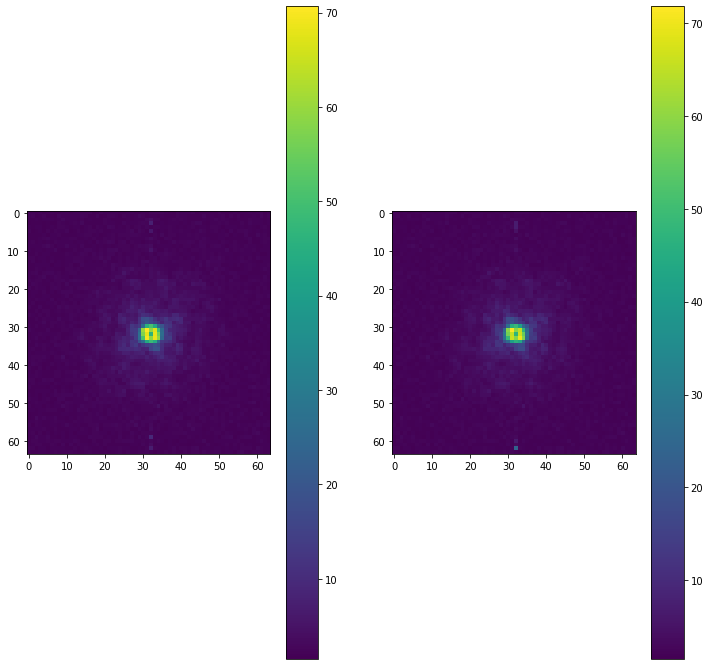

In [211]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec_o1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec_o2))); plt.colorbar()

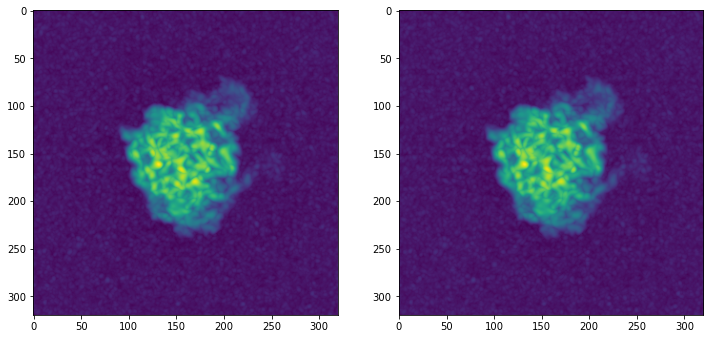

In [212]:
v_rec_ol1, _ = rescale_larger_grid(v_rec_o1, x_grid, nx0)
vr_o1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol1)))

v_rec_ol2, _ = rescale_larger_grid(v_rec_o2, x_grid, nx0)
vr_o2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol2)))

plt.subplot(1,2,1)
mip_z(vr_o1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_o2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [213]:
with mrcfile.new(f"{out_dir}/v_rec_o1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_o2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o2.astype(np.float32))   

Text(0.5, 1.0, 'FSC')

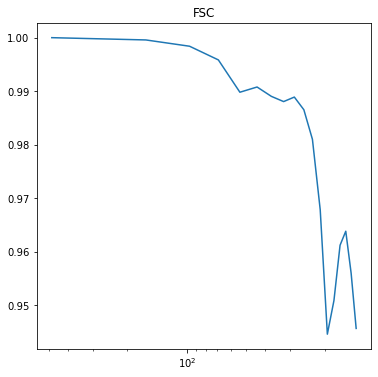

In [214]:
res, fsc_o, shell_points = calc_fsc(v_rec_o1, v_rec_o2, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_o)
plt.gca().invert_xaxis()
plt.title("FSC")

In [215]:
print(fsc_o[11])
print(fsc_o[12])
print(res_angs[11])
print(res_angs[12])

0.9678422164873853
0.9445843995043346
21.04567242124271
19.362018627543293


In [216]:
Nn = N//2

In [221]:
loss_func1(v_rec1, jnp.arange(Nn))

DeviceArray(3.40415497e+08, dtype=float64)

In [222]:
loss_func2(v_rec2, jnp.arange(Nn))

DeviceArray(3.39795062e+08, dtype=float64)

In [223]:
loss_func1(v_rec_o1, jnp.arange(Nn))

DeviceArray(3.40701174e+08, dtype=float64)

In [224]:
loss_func2(v_rec_o2, jnp.arange(Nn))

DeviceArray(3.40078246e+08, dtype=float64)

#### Now the same with CG

In [227]:
N_iter = 300


In [228]:
AA1, Ab1 = get_cg_vol_ops(gradv_obj.grad_loss_volume_sum, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], v_rec1.shape, sigma_noise)
AA2, Ab2 = get_cg_vol_ops(gradv_obj.grad_loss_volume_sum, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], v_rec1.shape, sigma_noise)


In [229]:

v_rec_cg1, _ = cg(AA1, Ab1, x0, N_iter, verbose=True)

  cg iter 0 ||r|| = 396.74461153141954
  cg iter 10 ||r|| = 25.754223107604712
  cg iter 20 ||r|| = 5.412342547078373
  cg iter 30 ||r|| = 1.6581564652645213
  cg iter 40 ||r|| = 0.6274537140382689
  cg iter 50 ||r|| = 0.33550778359356986
  cg iter 60 ||r|| = 0.23903684882125892
  cg iter 70 ||r|| = 0.15905156923560157
  cg iter 80 ||r|| = 0.13204600682503606
  cg iter 90 ||r|| = 0.11710469399341526
  cg iter 100 ||r|| = 0.08466840391408582
  cg iter 110 ||r|| = 0.06840129708969017
  cg iter 120 ||r|| = 0.0635609429688596
  cg iter 130 ||r|| = 0.052331506110203055
  cg iter 140 ||r|| = 0.03629752669811031
  cg iter 150 ||r|| = 0.03522267485241166
  cg iter 160 ||r|| = 0.03788764848524145
  cg iter 170 ||r|| = 0.03399469547518016
  cg iter 180 ||r|| = 0.02639603700200574
  cg iter 190 ||r|| = 0.024099135706875406
  cg iter 200 ||r|| = 0.020232964812717302
  cg iter 210 ||r|| = 0.015400375158218895
  cg iter 220 ||r|| = 0.011459808409231777
  cg iter 230 ||r|| = 0.010615882318838638
  cg

In [230]:
v_rec_cg2, _ = cg(AA2, Ab2, x0, N_iter, verbose=True)

  cg iter 0 ||r|| = 388.9908377168749
  cg iter 10 ||r|| = 24.345358401879555
  cg iter 20 ||r|| = 5.207530603318702
  cg iter 30 ||r|| = 1.487366959977394
  cg iter 40 ||r|| = 0.5323690098071201
  cg iter 50 ||r|| = 0.29203042770001814
  cg iter 60 ||r|| = 0.20771599547374442
  cg iter 70 ||r|| = 0.15723714068255173
  cg iter 80 ||r|| = 0.13619351913198335
  cg iter 90 ||r|| = 0.11935322889356662
  cg iter 100 ||r|| = 0.10516582392459811
  cg iter 110 ||r|| = 0.10255819903341798
  cg iter 120 ||r|| = 0.09133426061517083
  cg iter 130 ||r|| = 0.0692781665247167
  cg iter 140 ||r|| = 0.055105817700867185
  cg iter 150 ||r|| = 0.051636844938020246
  cg iter 160 ||r|| = 0.04971407349223421
  cg iter 170 ||r|| = 0.03837287715019221
  cg iter 180 ||r|| = 0.025146153445866966
  cg iter 190 ||r|| = 0.02151577349550384
  cg iter 200 ||r|| = 0.020729812668979684
  cg iter 210 ||r|| = 0.017664492184113045
  cg iter 220 ||r|| = 0.012813091556781094
  cg iter 230 ||r|| = 0.009004344211686539
  cg 

In [231]:
Nn=N//2

In [232]:
loss_func1(v_rec_cg1, jnp.arange(Nn))

DeviceArray(3.18064717e+08, dtype=float64)

In [233]:
loss_func2(v_rec_cg2, jnp.arange(Nn))

DeviceArray(3.17710731e+08, dtype=float64)

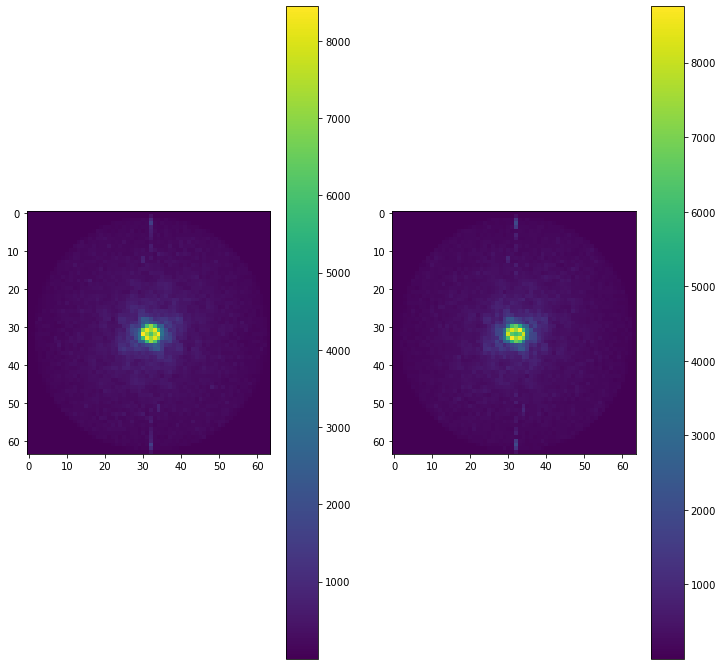

In [234]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec_cg1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec_cg2))); plt.colorbar()

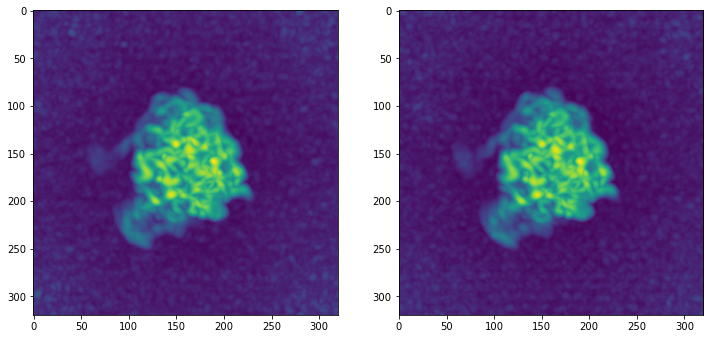

In [235]:
v_rec_cgl1, _ = rescale_larger_grid(v_rec_cg1, x_grid, nx0)
vr_cg1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_cgl1)))

v_rec_cgl2, _ = rescale_larger_grid(v_rec_cg2, x_grid, nx0)
vr_cg2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_cgl2)))

plt.subplot(1,2,1)
mip_z(vr_cg1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_cg2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [236]:
with mrcfile.new(f"{out_dir}/v_rec_cg1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_cg1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_cg2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_cg2.astype(np.float32))  

Text(0.5, 1.0, 'FSC')

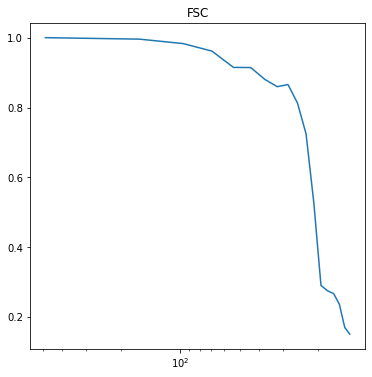

In [237]:
res, fsc_cg, shell_points = calc_fsc(v_rec_cg1, v_rec_cg2, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_cg)
plt.gca().invert_xaxis()
plt.title("FSC")

In [238]:
print(fsc_cg[11])
print(fsc_cg[12])
print(res_angs[11])
print(res_angs[12])

0.5264741775316928
0.290546756393578
21.04567242124271
19.362018627543293


#### Some conclusions:

##### Running without $\sigma_{noise}$, nx_crop=64, 10,000 images in each half set:
* FSC SGD is above 0.94 all the way when using the correct preconditionner (30 epochs)
* FSC Oasis is almost identical to SGD with precon, the FSC is almost the same (30 epochs)
* CG 300 iters i.e. epochs, FSC=0.5 at 20 Angs

### Newton's method vs GD vs CG

#### GD - a pain to tune 

In [ ]:
Ngd = 1000

N_epochs = 200
batch_size = Ngd
step_size = 10000 # 1e-3

idx = np.arange(Ngd)

grad_func, loss_func = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [ ]:
v_rec_gd, loss_rec_gd, grad_rec_gd = sgd(grad_func, loss_func1, Ngd, x0, step_size, N_epochs, batch_size, verbose=True, iter_display=10)


In [ ]:
plt.plot(loss_rec_gd)

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

In [ ]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [ ]:
key, subkey = random.split(key)

A = random.normal(subkey, (n,n))
A = A.T + A

plt.imshow(A); plt.colorbar()

In [ ]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

#z * A @ z 

In [ ]:
zAz = jax.vmap(lambda zi : zi * (A @ zi))(z)
#plt.imshow(zAz)

In [ ]:
d = np.zeros((iters, n))
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i-1] + zAz[i]
    
for i in range(1, iters):
    d[i] = d[i]/(i+1)

In [ ]:
err = jnp.mean((d - jnp.diag(A))**2, axis=1)

In [ ]:
plt.semilogy(err)

#### Hessian-vector product in JaX

In [ ]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [ ]:
b = A @ x0 
f = lambda x : jnp.mean((A @ x - b)**2)

In [ ]:
f(x0)

In [ ]:
from jax import jvp, grad

# Naive
def hvp0(f, x, v):
    return grad(lambda x : jnp.vdot(grad(f)(x), v))(x)

# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [ ]:
t0 = time.time()
v1 = hvp0(f, x, v).block_until_ready()
print(time.time()-t0)

t0 = time.time()
v2 = hvp(f, (x,), (v,)).block_until_ready()
print(time.time()-t0)

jnp.sum(jnp.abs(v1-v2))

#### Toy problem

In [ ]:
key, *subkey = random.split(key, 4)

x_gt = random.normal(subkey[0], (n,))

A = np.random.normal(size = (n,n))
A = A.T @ A
_, v = jnp.linalg.eigh(A)
d = jnp.flip(jnp.logspace(-5,1,n)) 
d = d + jnp.abs(jnp.min(d)*2)
A = v.T @ jnp.diag(d) @ v

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort(evals))


assert(jnp.sum(evals < 0) == 0)
#assert(jnp.max(jnp.abs(A.T - A)) == 0)
#assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)


plt.semilogy(evals, '.')
plt.title("Eigenvalues")
print(f"Condition number = {evals[0]/evals[n-1] : .2e}")

In [ ]:
sig_noise = 1
lam = 0.1

b = A @ x_gt  + np.random.normal(size=(n,)) * sig_noise

F = jax.jit(lambda x : jnp.sum((A @ x - b)**2) + lam * jnp.mean(x**2))
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.jit(jax.grad(F))
hessianF = jax.hessian(F)

hvpF = jax.jit(lambda x, v : hvp(F, (x,), (v,)))

print(f"gradF(x_gt) = {gradF(x_gt)}")
print(f"hessianF(x_gt) = {hessianF(x_gt)}")


In [ ]:
def gd(F, gradF, eta, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        w1 = w0 - eta * gradF(w0)
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

def newton(F, gradF, hessianF, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        G = gradF(w0)
        H = hessianF(w0)
        
        w1 = w0 - jnp.linalg.inv(H) @ G
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

In [ ]:
N_iter = 10000
eta = 1e-3 #0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display = 200)

In [ ]:
plt.semilogy(loss_gd)

In [ ]:
N_iter = 10

x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

In [ ]:
plt.plot(loss_n)

In [ ]:
N_iter = 10000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = jax.jit(lambda vv : jnp.conj(gradF(vv)) + Ab)

x_cg, kk = cg(AA, Ab, x0, N_iter, verbose=True)

In [ ]:
F(x_cg)

#### OASIS

In [ ]:
Fidx = jax.jit(lambda x, idx : F(x))
gradFidx = jax.jit(lambda x, idx : jax.grad(F)(x))
hvpFidx = jax.jit(lambda x, v, idx : hvp(F, (x,), (v,)))

In [ ]:
# Estimating D0

iters = 10000
key, *subkeys = random.split(key, iters+1)
zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[i], (n,), dtype=x0.dtype)
    
    zD0z += z * hvpFidx(x0, z, 1)
    
D0 = jnp.array(zD0z/iters)

D0exact = jnp.diag(hessianF(x0)) # Cheating a bit


In [ ]:
plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [ ]:
N_iter = 10000
beta2 = 0.99
eta = 0.01 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_iter, iter_display = 500)


In [ ]:
N_iter = 10000
beta2 = 0.99
eta0 = 0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta0, D0, beta2, alpha, N_iter, iter_display = 500)


In [ ]:
print(jnp.max(jnp.abs(x_gt-x_n)))
print(jnp.max(jnp.abs(x_gt-x_cg)))
print(jnp.max(jnp.abs(x_gt-x_gd)))
print(jnp.max(jnp.abs(x_gt-x_o)))
print(jnp.max(jnp.abs(x_gt-x_oa)))

plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)

nn0 = 0
nn1 = 2000
#plt.semilogy(loss_n[nn0:nn1])
plt.semilogy(loss_gd[nn0:nn1])
plt.semilogy(loss_o[nn0:nn1])
plt.semilogy(loss_oa[nn0:nn1])
#plt.legend(["Newton", "GD", "OASIS", "OASIS adaptive"])
plt.legend(["GD", "OASIS", "OASIS adaptive"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_gt-x_n))
plt.semilogy(jnp.abs(x_gt-x_gd))
plt.semilogy(jnp.abs(x_gt-x_o))
plt.semilogy(jnp.abs(x_gt-x_oa))
plt.legend(["Newton", "GD", "OASIS", "OASIS_adaptive"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6, 6

### Stochastic - sum of operators

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

Generate $N$ operators to create a loss function to do SGD/OASIS on:

In [ ]:
sig_noise = 10
lam = 0.1

In [ ]:
n = 100
N = 1000

x_gt = np.random.normal(size=(n,))

ops = []
b = []
for i in range(N):
    A = np.random.normal(size=(n,n))
    A = A.T @ A
    _, v = jnp.linalg.eigh(A)
    
    d = jnp.flip(jnp.logspace(-5,4,n)) + np.random.normal(size=(n,))*10 
    d = d + jnp.abs(jnp.min(d)*2)
                 
    A = v.T @ jnp.diag(d) @ v
    ops.append(A)
    
    bn = A @ x_gt + np.random.normal(size=(n,)) * sig_noise
    b.append(bn)
    
    #print(jnp.mean((A@x_gt - bn)**2))
    
ops = jnp.array(ops)
b = jnp.array(b)

In [ ]:
w, _ = jnp.linalg.eigh(A)
w = jnp.flip(jnp.sort(w))
print(f"{jnp.max(w)/jnp.min(w) : .2e}")

In [ ]:
def loss_term(x, A, b):
    return 1/2 * jnp.mean((A@x - b)**2) + lam * jnp.mean(x**2)

def loss_func(x, ops, b):
    return jnp.mean(jax.vmap(loss_term, in_axes = (None, 0, 0))(x, ops, b))

def grad_loss_func(x, ops, b):
    return jax.grad(loss_func)(x, ops, b)

def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y : grad_loss_func(y, ops, b), (x,), (v,))[1]

In [ ]:
idx = np.random.permutation(N)[:N//3]

print(loss_term(x_gt, ops[0], b[0]))
print(loss_func(x_gt, ops, b))

print(grad_loss_func(x_gt, ops, b).shape)
print(grad_loss_func(x_gt, ops[idx], b[idx]).shape)

print(hvp_loss_func(x_gt, x_gt, ops, b).shape)
print(hvp_loss_func(x_gt, x_gt, ops[idx], b[idx]).shape)

In [ ]:
hessianF = lambda x : jax.hessian(loss_func)(x, ops, b)

Fidx = jax.jit(lambda x, idx : loss_func(x, ops[idx], b[idx]))
gradFidx = jax.jit(lambda x, idx : grad_loss_func(x, ops[idx], b[idx]))
hvpFidx = jax.jit(lambda x, v, idx : hvp_loss_func(x, v, ops[idx], b[idx]))
x0 = jnp.array(np.random.randn(n))

In [ ]:
Fidx(x_gt, jnp.arange(N))

In [ ]:
#D0 = jnp.ones((nx,nx,nx))  #<--- not very good

iters = 10000
batch_sz = 32
key, *subkeys = random.split(key, 2*iters+1)

zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], (n,), dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N)[:batch_sz]
    
    zD0z += z * hvpFidx(x0, z, idx)
    
D0 = jnp.array(zD0z/iters)

D0exact = jnp.diag(hessianF(x0)) # Cheating a bit

plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_os, loss_os = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_osa, loss_osa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


In [ ]:
N_epoch = 10
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)

In [ ]:
N_epoch = 10
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)


In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-6
                       
key, subkey = random.split(key)
x_sgd, loss_sgd, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, verbose = True, iter_display = 1)

In [ ]:
plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)
plt.semilogy(loss_sgd)
#plt.semilogy(loss_o)
plt.semilogy(loss_os)
#plt.semilogy(loss_oa)
plt.semilogy(loss_osa)
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_sgd-x_gt))
#plt.semilogy(jnp.abs(x_o-x_gt))
plt.semilogy(jnp.abs(x_os-x_gt))
#plt.semilogy(jnp.abs(x_oa-x_gt))
plt.semilogy(jnp.abs(x_osa-x_gt))
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

Next:

* ~~Run the new OASIS algorithms on the old (deterministic one operator) toy problem~~
* ~~Implement the adaptive version of the stochastic OASIS~~
* ~~Add noise and rerun all the experiments~~
* In the stochastic toy problem case, also compare with CG (make the problem small enough so that we can do CG)
* ~~Implement some kind of warm up /estimation of $D_0$~~
* Run on CryoEM data